In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import xarray as xr
import sys
import os
from re import split
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.utils import get_pars_from_ini
location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(campaign='loc')[location]['path_data']
path_proj = get_pars_from_ini(campaign='loc')[location]['path_proj']
plt.style.use('seaborn')

In [2]:
zhh14 = pd.read_csv('../results/df_filtered/zhh14_merged_Wn_Ws.csv')
zhh14['time'] = pd.to_datetime(zhh14.time)
zhh14.index = zhh14.time
zhh14.drop(columns='time', inplace=True)
zhh14 = zhh14.assign(Location=1)

In [3]:
zhh14

,area,perimeter,min_row,min_col,max_row,max_col,depth,width,max_zhh,alt3d,...,perimeter_km,depth_km,width_km,cloud_top,cloud_base,axis_ratio,axis_ratio_inv,day,vuelo,Location
time,,,,,,,,,,,,,,,,,,,,,
2019-08-24 23:05:44.899800,3522.0,375.628463,6.12,5.70,7.71,9.18,113.663297,44.330907,28.932385,9309.001289,...,11.268854,3.409899,1.329927,3.189001,1.599001,2.563974,0.390020,2019-08-24,RF01,1
2019-08-24 23:05:46.749800,6811.0,406.184812,5.97,5.10,8.76,9.36,140.465556,65.605700,39.583701,9308.915433,...,12.185544,4.213967,1.968171,3.338915,0.548915,2.141057,0.467059,2019-08-24,RF01,1
2019-08-24 23:05:48.599800,9445.0,464.398016,5.91,5.13,8.76,9.39,134.412045,95.870336,41.583087,9308.541724,...,13.931940,4.032361,2.876110,3.398542,0.548542,1.402019,0.713257,2019-08-24,RF01,1
2019-08-24 23:05:54.149800,10147.0,569.581782,6.15,4.11,8.79,9.78,180.123643,80.021387,41.931806,9307.949805,...,17.087453,5.403709,2.400642,3.157950,0.517950,2.250944,0.444258,2019-08-24,RF01,1
2019-08-24 23:05:55.999800,8434.0,707.788889,6.45,4.20,8.79,9.81,184.076795,71.978511,40.008396,9307.957460,...,21.233667,5.522304,2.159355,2.857957,0.517957,2.557385,0.391024,2019-08-24,RF01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-05 06:33:56.699800,28926.0,741.522907,3.87,1.62,8.55,9.03,245.903899,154.829688,45.524043,9069.686550,...,22.245687,7.377117,4.644891,5.199687,0.519687,1.588222,0.629635,2019-10-05,RF25,1
2019-10-05 06:33:58.549800,27829.0,707.522907,3.99,1.59,8.55,8.76,238.300875,153.855254,46.221086,9064.746440,...,21.225687,7.149026,4.615658,5.074746,0.514746,1.548864,0.645634,2019-10-05,RF25,1
2019-10-05 06:34:00.399800,26963.0,705.144228,4.05,1.59,8.55,8.67,237.874513,150.240393,43.635350,9055.242611,...,21.154327,7.136235,4.507212,5.005243,0.505243,1.583293,0.631595,2019-10-05,RF25,1


In [4]:
cols = list(zhh14.columns)


In [5]:
df_day = zhh14.groupby(zhh14.index.floor('d'))
flights = list(df_day.groups.keys())
dict_flights = {f'RF{i + 1:02d}':flights[i] for i in range(len(flights)) }
dict_fl = {flights[i]:f'RF{i + 1:02d}' for i in range(len(flights)) }

In [6]:
df_day.groups.keys()

dict_keys([Timestamp('2019-08-24 00:00:00'), Timestamp('2019-08-25 00:00:00'), Timestamp('2019-08-27 00:00:00'), Timestamp('2019-08-29 00:00:00'), Timestamp('2019-08-30 00:00:00'), Timestamp('2019-09-07 00:00:00'), Timestamp('2019-09-09 00:00:00'), Timestamp('2019-09-14 00:00:00'), Timestamp('2019-09-15 00:00:00'), Timestamp('2019-09-16 00:00:00'), Timestamp('2019-09-17 00:00:00'), Timestamp('2019-09-19 00:00:00'), Timestamp('2019-09-20 00:00:00'), Timestamp('2019-09-21 00:00:00'), Timestamp('2019-09-22 00:00:00'), Timestamp('2019-09-24 00:00:00'), Timestamp('2019-09-25 00:00:00'), Timestamp('2019-09-27 00:00:00'), Timestamp('2019-09-28 00:00:00'), Timestamp('2019-09-29 00:00:00'), Timestamp('2019-10-01 00:00:00'), Timestamp('2019-10-05 00:00:00')])

In [7]:
dict_flights

{'RF01': Timestamp('2019-08-24 00:00:00'),
 'RF02': Timestamp('2019-08-25 00:00:00'),
 'RF03': Timestamp('2019-08-27 00:00:00'),
 'RF04': Timestamp('2019-08-29 00:00:00'),
 'RF05': Timestamp('2019-08-30 00:00:00'),
 'RF06': Timestamp('2019-09-07 00:00:00'),
 'RF07': Timestamp('2019-09-09 00:00:00'),
 'RF08': Timestamp('2019-09-14 00:00:00'),
 'RF09': Timestamp('2019-09-15 00:00:00'),
 'RF10': Timestamp('2019-09-16 00:00:00'),
 'RF11': Timestamp('2019-09-17 00:00:00'),
 'RF12': Timestamp('2019-09-19 00:00:00'),
 'RF13': Timestamp('2019-09-20 00:00:00'),
 'RF14': Timestamp('2019-09-21 00:00:00'),
 'RF15': Timestamp('2019-09-22 00:00:00'),
 'RF16': Timestamp('2019-09-24 00:00:00'),
 'RF17': Timestamp('2019-09-25 00:00:00'),
 'RF18': Timestamp('2019-09-27 00:00:00'),
 'RF19': Timestamp('2019-09-28 00:00:00'),
 'RF20': Timestamp('2019-09-29 00:00:00'),
 'RF21': Timestamp('2019-10-01 00:00:00'),
 'RF22': Timestamp('2019-10-05 00:00:00')}

In [8]:
zhh35 = pd.read_csv('../results/df_filtered/zhh35_merged_Wn_Ws.csv')
zhh35['time'] = pd.to_datetime(zhh35.time)
zhh35.index = zhh35.time
zhh35.drop(columns='time', inplace=True)
zhh35 = zhh35.assign(Location=2)

In [9]:
zhh95 = pd.read_csv('../results/df_filtered/zhh95.csv')
zhh95['time'] = pd.to_datetime(zhh95.time)
zhh95.index = zhh95.time
zhh95.drop(columns='time', inplace=True)
zhh95 = zhh95.assign(Location=3)


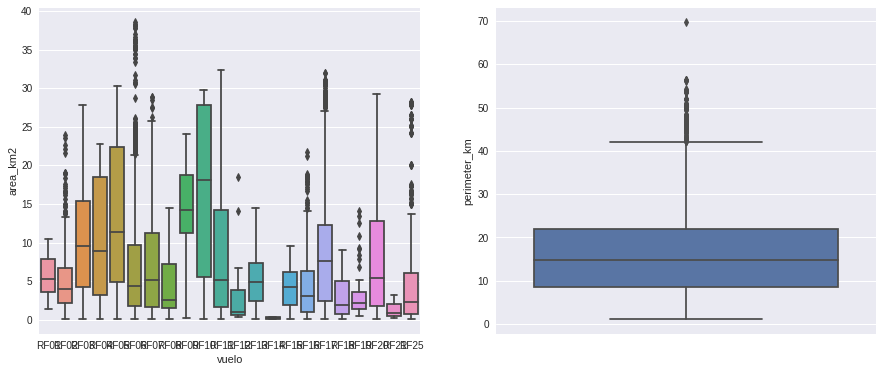

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
bxp1 = sns.boxplot(x='vuelo', y='area_km2',data=zhh14, ax=ax[0])
bxp2 = sns.boxplot(y='perimeter_km',data=zhh14, ax=ax[1])

In [12]:
cdf = pd.concat([zhh14, zhh35, zhh95])                             # CONCATENATE


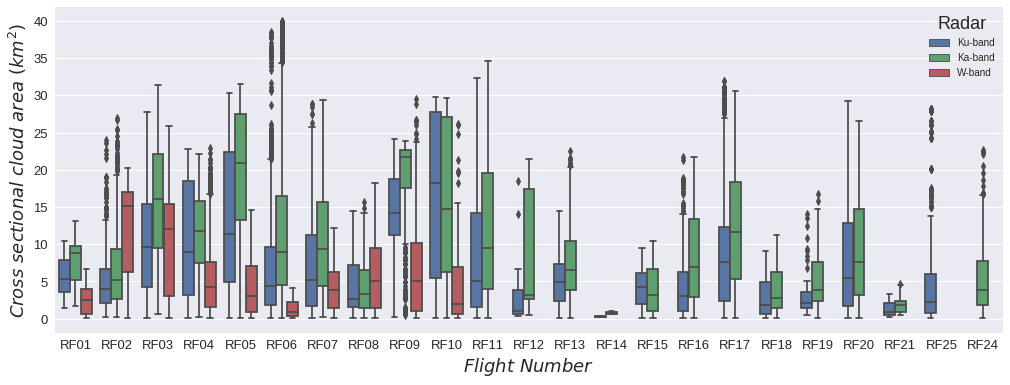

In [18]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='area_km2', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ cloud \ area \ (km^{2})$', **axis_font)
legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/Area.jpg', bbox_inches="tight", dpi=300)
plt.show()

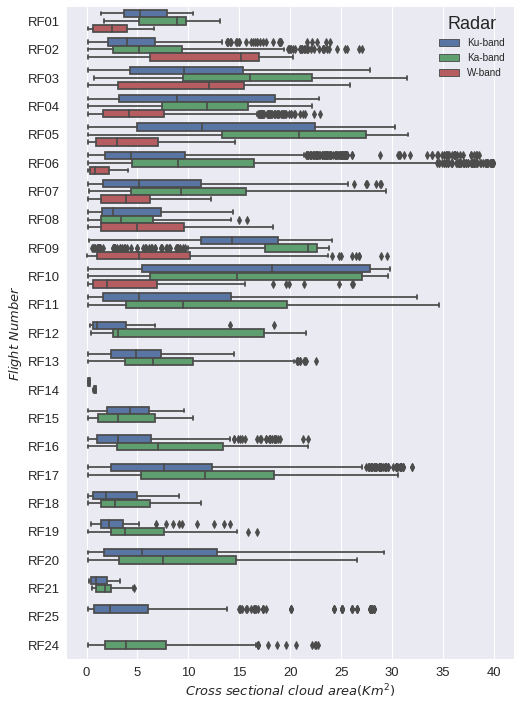

In [14]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'13'}
fig, ax = plt.subplots( figsize=(8, 12))
ax = sns.boxplot(x='area_km2', y='vuelo', hue='Location',data=cdf, ax=ax)
ax.set_ylabel('$Flight \ Number$', **axis_font)
ax.set_xlabel('$Cross \ sectional \ cloud \ area (Km^{2})$', **axis_font)
legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/Area_vertical.jpg', bbox_inches="tight", dpi=300)
plt.show()

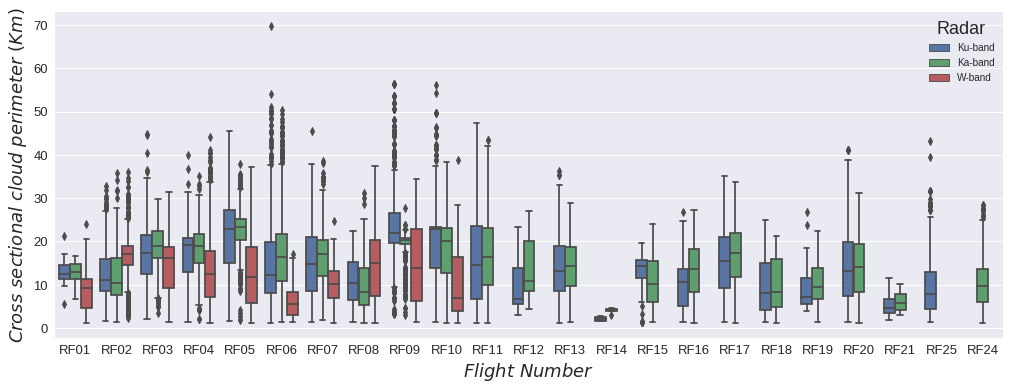

In [19]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='perimeter_km', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ cloud \ perimeter \ (Km)$', **axis_font)
legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/Perimeter_uncol.jpg', bbox_inches="tight", dpi=300)
plt.show()

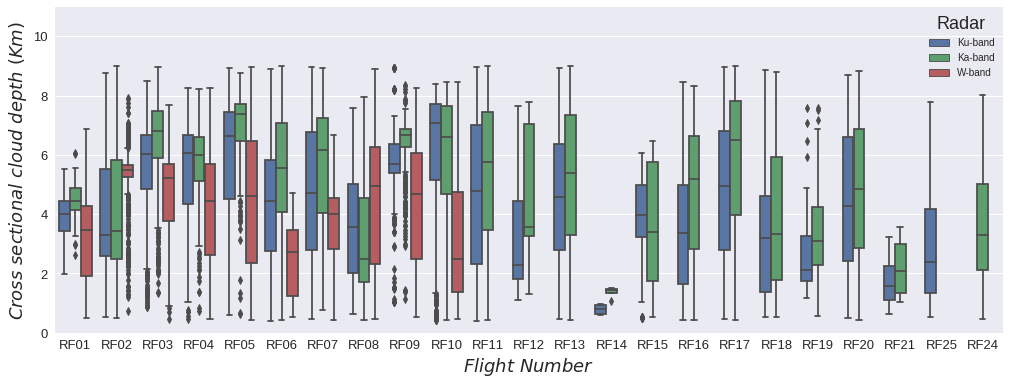

In [20]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='depth_km', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ cloud \ depth \ (Km)$', **axis_font)
ax.set_ylim(0, 11)
ax.legend(loc='upper right')

legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/Cloud_depth_uncol.jpg', bbox_inches="tight", dpi=300)
plt.show()

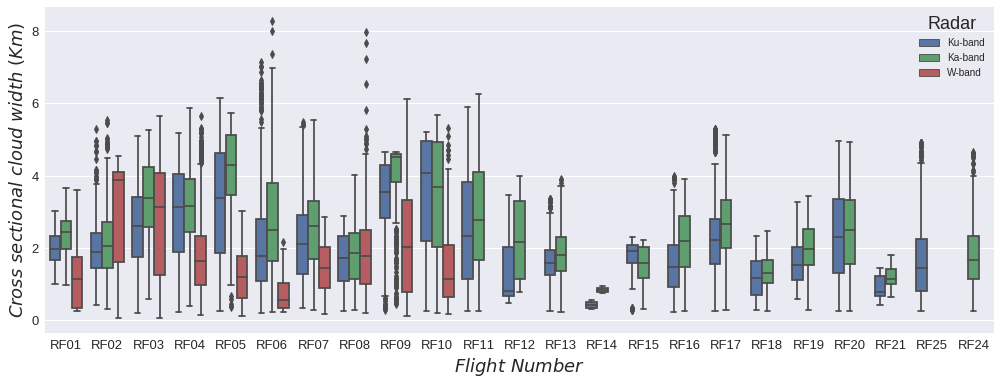

In [21]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='width_km', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ cloud \ width \ (Km)$', **axis_font)
# ax.set_ylim(0, 11)
ax.legend(loc='upper right')

legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/Cloud_width_uncol.jpg', bbox_inches="tight", dpi=300)
plt.show()

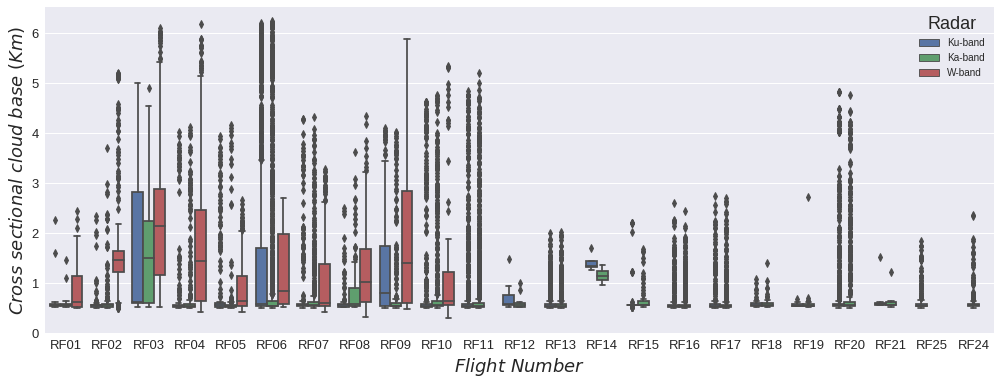

In [22]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='cloud_base', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ cloud \ base \ (Km)$', **axis_font)
# ax.set_ylim(0, 11)
ax.legend(loc='upper right')

legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/Cloud_base_uncol.jpg', bbox_inches="tight", dpi=300)
plt.show()

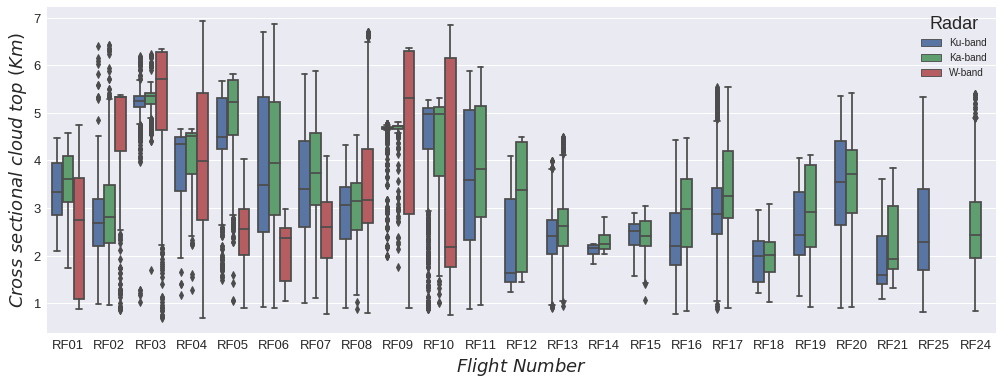

In [24]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='cloud_top', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ cloud \ top \ (Km)$', **axis_font)
# ax.set_ylim(0, 11)
ax.legend(loc='upper right')

legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/Cloud_top_uncol.jpg', bbox_inches="tight", dpi=300)
plt.show()

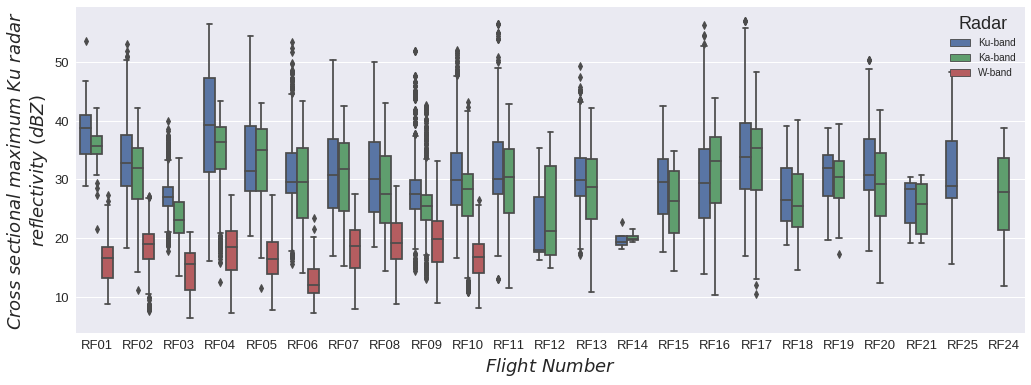

In [31]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='max_zhh', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ maximum \ Ku \ radar$' + '\n'+ '$reflectivity \ (dBZ)$', **axis_font)
# ax.set_ylim(0, 11)
ax.legend(loc='upper right')

legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar", loc='upper right')

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/reflectivity_uncol.jpg', bbox_inches="tight", dpi=300)
plt.show()

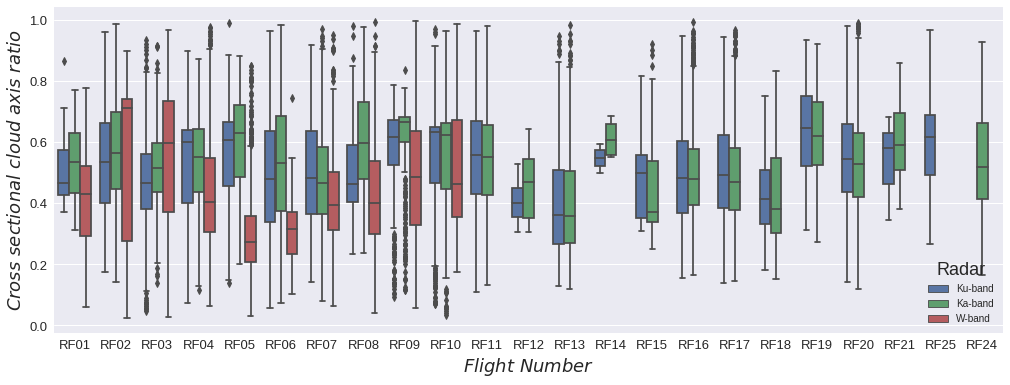

In [32]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'18'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='axis_ratio_inv', hue='Location',data=cdf, ax=ax)
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Cross \ sectional \ cloud \ axis \ ratio$', **axis_font)
# ax.set_ylim(0, 11)
ax.legend(loc='upper right')

legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/axis_ratio_inv_unc.jpg', bbox_inches="tight", dpi=300)
plt.show()

In [18]:
times_zhh14 = zhh14.index
times_zhh35 = zhh35.index
times_zhh95 = zhh95.index

In [19]:
cluster = SLURMCluster(queue="seseml",
                       memory='200GB',
                       cores=40,
                       processes=1,
                       walltime='23:40:00',
                       scheduler_options={'host': '172.22.179.3:7227', 'dashboard_address': ':7798'})

In [20]:
cluster.adapt(maximum_jobs=4)
cluster

In [21]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.22.179.3:7798/status,
Dashboard: http://172.22.179.3:7798/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.22.179.3:7227,Workers: 0
Dashboard: http://172.22.179.3:7798/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [22]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAs_Wn/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
ds_vel14 = ds_xr.vel14.max(dim=['cross_track', 'range'])
ds_vel35 = ds_xr.vel35.max(dim=['cross_track', 'range'])
ds_vel95 = ds_xr.vel95s.max(dim=['cross_track', 'range'])

In [23]:
ds_xr = xr.open_zarr(f'{path_data}/zarr_rckd/KUsKAsWs/lores.zarr')
ds_xr = ds_xr.sel(time=~ds_xr.get_index("time").duplicated())
ds_vel14_2 = ds_xr.vel14.max(dim=['cross_track', 'range'])
ds_vel35_2 = ds_xr.vel35.max(dim=['cross_track', 'range'])
ds_vel95 = ds_xr.vel95s.max(dim=['cross_track', 'range']).to_dataframe()


In [25]:
ds_vel95.rename(columns={'vel95s': 'vel'}, inplace=True)

In [26]:
df_vel14 = xr.concat([ds_vel14, ds_vel14_2], dim='time').to_dataframe()

In [27]:
df_vel14.rename(columns={'vel14': 'vel'}, inplace=True)

In [28]:
df_vel35 = xr.concat([ds_vel35, ds_vel35_2], dim='time').to_dataframe()

In [29]:
df_vel35.rename(columns={'vel35': 'vel'}, inplace=True)

In [30]:
df_vel14 = df_vel14.assign(Location=1)

In [31]:
df_vel35 = df_vel35.assign(Location=2)

In [32]:
df_vel95 = ds_vel95.assign(Location=3)

In [33]:
df_vel = pd.concat([df_vel14, df_vel35, df_vel95])

In [35]:
df_vel = df_vel.merge(cdf, left_index=True, right_index=True)

In [39]:
df_vel

,vel,Location_x,area,perimeter,min_row,min_col,max_row,max_col,depth,width,...,perimeter_km,depth_km,width_km,cloud_top,cloud_base,axis_ratio,axis_ratio_inv,day,vuelo,Location_y
time,,,,,,,,,,,,,,,,,,,,,
2019-08-24 23:05:44.899800,27.706892,1,3522.0,375.628463,6.12,5.70,7.71,9.18,113.663297,44.330907,...,11.268854,3.409899,1.329927,3.189001,1.599001,2.563974,0.390020,2019-08-24,RF01,1
2019-08-24 23:05:44.899800,27.706892,1,5617.0,362.391919,5.97,5.16,7.86,9.36,140.047616,53.567675,...,10.871758,4.201428,1.607030,3.339001,1.449001,2.614405,0.382496,2019-08-24,RF01,2
2019-08-24 23:05:44.899800,10.522915,2,3522.0,375.628463,6.12,5.70,7.71,9.18,113.663297,44.330907,...,11.268854,3.409899,1.329927,3.189001,1.599001,2.563974,0.390020,2019-08-24,RF01,1
2019-08-24 23:05:44.899800,10.522915,2,5617.0,362.391919,5.97,5.16,7.86,9.36,140.047616,53.567675,...,10.871758,4.201428,1.607030,3.339001,1.449001,2.614405,0.382496,2019-08-24,RF01,2
2019-08-24 23:05:46.749800,27.901078,1,6811.0,406.184812,5.97,5.10,8.76,9.36,140.465556,65.605700,...,12.185544,4.213967,1.968171,3.338915,0.548915,2.141057,0.467059,2019-08-24,RF01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-05 06:47:12.899800,10.458290,2,3055.0,261.279221,5.73,2.19,7.08,5.28,102.922282,41.186724,...,7.838377,3.087668,1.235602,1.952726,0.602726,2.498919,0.400173,2019-10-05,RF24,2
2019-10-05 06:47:14.749800,27.864202,1,1020.0,172.124892,5.88,2.55,6.81,4.89,71.013811,28.883347,...,5.163747,2.130414,0.866500,1.803481,0.873481,2.458642,0.406729,2019-10-05,RF25,1
2019-10-05 06:47:14.749800,27.864202,1,2162.0,233.480231,5.79,2.43,7.02,5.10,92.150974,36.363496,...,7.004407,2.764529,1.090905,1.893481,0.663481,2.534162,0.394608,2019-10-05,RF24,2


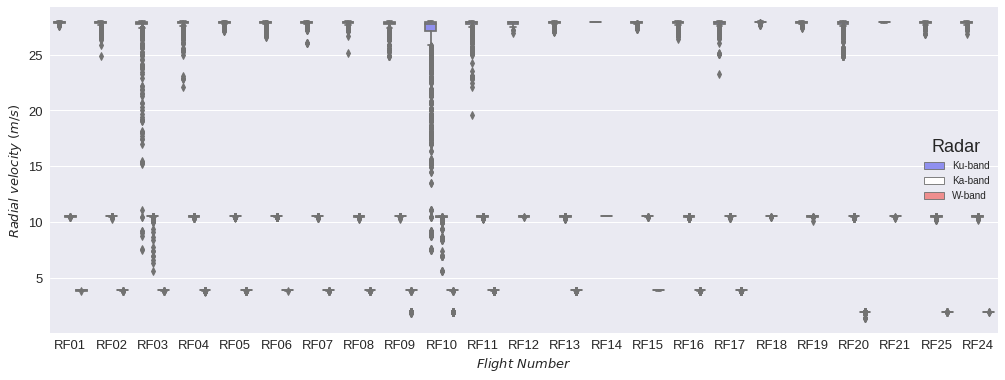

In [42]:
plt.rcParams.update({'font.size': 18})
axis_font = {'size':'13'}
fig, ax = plt.subplots( figsize=(17, 6))
ax = sns.boxplot(x='vuelo', y='vel', hue='Location_x',data=df_vel, ax=ax, palette="bwr")
ax.set_xlabel('$Flight \ Number$', **axis_font)
ax.set_ylabel('$Radial \ velocity \ (m/s)$', **axis_font)
# ax.set_ylim(0, 11)
ax.legend(loc='upper right')
# ax.set_yscale('log')
legend_label = ["Ku-band", "Ka-band", "W-band"]
ax.legend(title="Radar")

n = 0
for i in legend_label:
    ax.legend_.texts[n].set_text(i)
    n += 1
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)
    
fig.savefig('../results/df_filtered/velocity.jpg', bbox_inches="tight", dpi=300)
plt.show()

In [17]:
10 * 10000 + 5e-3/2 * 10000**2

350000.0